In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet201

from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers, Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
batch_size = 64

In [4]:
# rescale normalizes the data for the images.
# Data is split into train and validation sets
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle = False,
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                             )

Found 5440 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
dnn201 = tf.keras.applications.DenseNet201(
    include_top=False,
    input_tensor=None,
    input_shape=(224,224,3),
    weights = 'imagenet'
)

dnn201.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(1, activation='sigmoid')

model = Sequential([
    dnn201,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
  
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [6]:
epochs = 11
history = model.fit(train_it,
                       validation_data=val_it,
                       epochs=epochs)


Epoch 1/11
85/85 [==============================] - 143s 2s/step - loss: 0.4231 - accuracy: 0.8357 - val_loss: 0.2380 - val_accuracy: 0.9096
Epoch 2/11
85/85 [==============================] - 122s 1s/step - loss: 0.1817 - accuracy: 0.9319 - val_loss: 0.1529 - val_accuracy: 0.9485
Epoch 3/11
85/85 [==============================] - 122s 1s/step - loss: 0.1236 - accuracy: 0.9532 - val_loss: 0.1352 - val_accuracy: 0.9485
Epoch 4/11
85/85 [==============================] - 122s 1s/step - loss: 0.1185 - accuracy: 0.9498 - val_loss: 0.0929 - val_accuracy: 0.9632
Epoch 5/11
85/85 [==============================] - 121s 1s/step - loss: 0.1092 - accuracy: 0.9616 - val_loss: 0.0642 - val_accuracy: 0.9728
Epoch 6/11
85/85 [==============================] - 123s 1s/step - loss: 0.1041 - accuracy: 0.9603 - val_loss: 0.0565 - val_accuracy: 0.9801
Epoch 7/11
85/85 [==============================] - 122s 1s/step - loss: 0.1018 - accuracy: 0.9616 - val_loss: 0.0667 - val_accuracy: 0.9765
Epoch 8/11
85

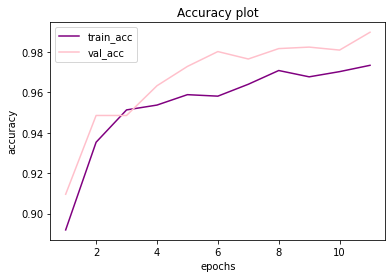

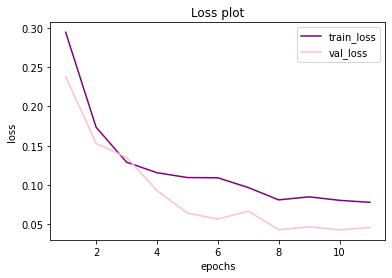

In [7]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [8]:
prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

22/22 - 25s


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [9]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [10]:
prediction.shape

(1360, 1)

In [11]:
val_labels.shape

(1360,)

In [12]:
results = model.evaluate(val_it)

22/22 [==============================] - 24s 1s/step - loss: 0.0409 - accuracy: 0.9846


0.9830882352941176
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       680
           1       0.99      0.98      0.98       680

    accuracy                           0.98      1360
   macro avg       0.98      0.98      0.98      1360
weighted avg       0.98      0.98      0.98      1360



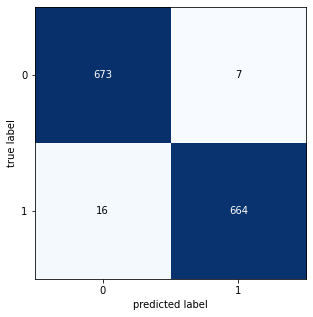

In [13]:
cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

AUC: 0.983


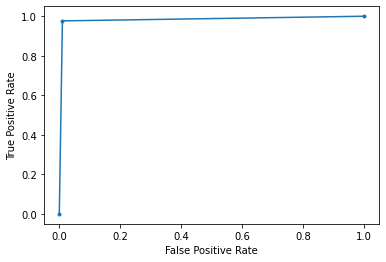

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(val_labels, prediction)
auc = metrics.roc_auc_score(val_labels, prediction)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr,marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Plots for Test Data: 200 images


In [17]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [18]:
test_labels=test_it.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [19]:
prediction1.shape

(200, 1)

In [20]:
test_labels.shape

(200,)

In [21]:
results = model.evaluate(test_it)

4/4 [==============================] - 4s 715ms/step - loss: 0.0222 - accuracy: 0.9900


1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



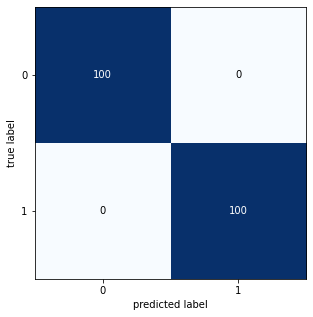

In [22]:
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))

AUC: 1.000


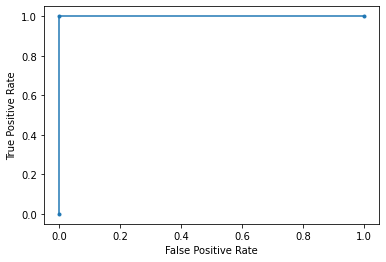

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, prediction1)
auc = metrics.roc_auc_score(test_labels, prediction1)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr,marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [33]:
model.save('/content/drive/MyDrive/denseNet201v2.h5')